# Movie Recommendation System

This project applies data mining techniques to build a robust movie recommendation system using the MovieLens dataset. 
The goal is to personalize movie suggestions based on user preferences by implementing collaborative filtering, content-based filtering, and hybrid models. 
This notebook follows a structured approach: data preprocessing, exploratory data analysis, model development, evaluation, and conclusion. 
It reflects knowledge gained through this course and provides both technical and interpretive insights on the outcomes.


In [1]:
# Movie Recommendation System

## Step 1: Load and Preprocess the Dataset
import pandas as pd
import numpy as np

In [2]:
# Load MovieLens dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')


In [3]:
# Merge datasets
movie_data = pd.merge(ratings, movies, on='movieId')
movie_data = pd.merge(movie_data, tags, on=['userId', 'movieId'], how='left')

# Handle missing values
movie_data.fillna("", inplace=True)

# Convert genres into a machine-readable format
from sklearn.preprocessing import MultiLabelBinarizer
movie_data['genres'] = movie_data['genres'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movie_data['genres'])


/var/folders/8s/2c0nnc016f3chm5qw194dz_m0000gn/T/ipykernel_4805/475939223.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  movie_data.fillna("", inplace=True)


In [4]:
movie_data

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",,
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",,
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",,
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",,
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",,
...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]",,
102673,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",Heroic Bloodshed,1493844270.0
102674,610,168250,5.0,1494273047,Get Out (2017),[Horror],,
102675,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]",,


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis helps in understanding the underlying structure of the dataset. 
We explore rating distributions, user activity, genre popularity, and trends over time to extract meaningful insights that guide model design.


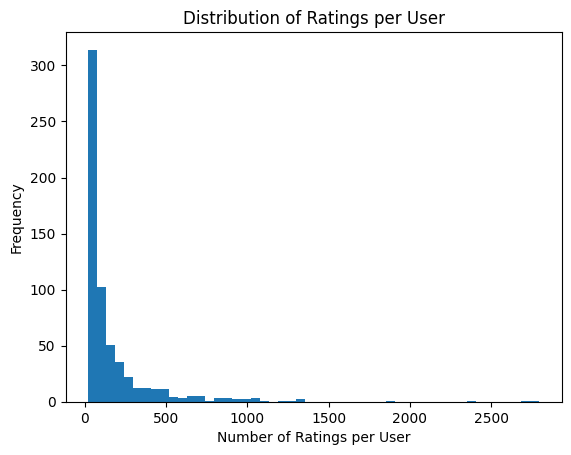

In [5]:
## Step 2: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze user activity
user_ratings_count = movie_data.groupby('userId').size()
plt.hist(user_ratings_count, bins=50)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings per User')
plt.show()


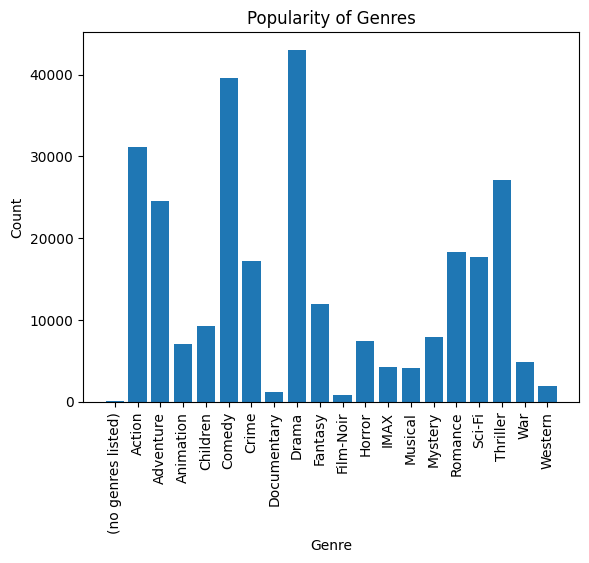

In [6]:
# Identify popular genres
genre_counts = genre_encoded.sum(axis=0)
plt.bar(mlb.classes_, genre_counts)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Popularity of Genres')
plt.show()

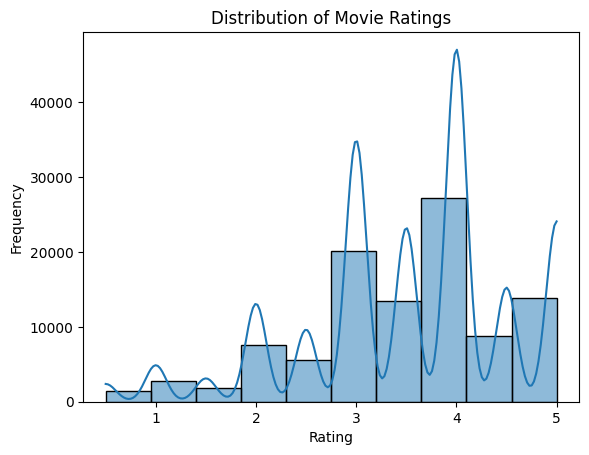

In [7]:
# Rating distribution
sns.histplot(movie_data['rating'], bins=10, kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

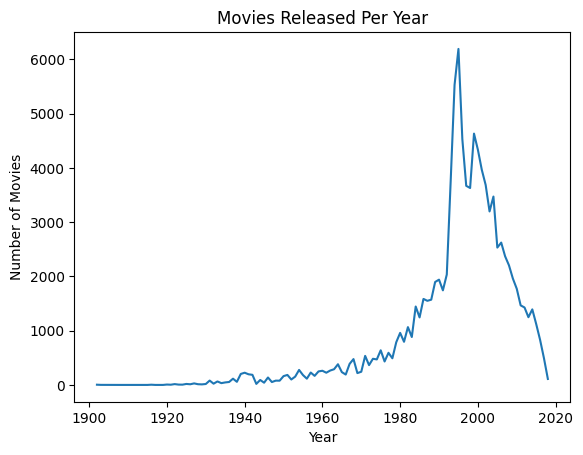

In [8]:
# Number of movies per year
movie_data['year'] = movie_data['title'].str.extract('\((\d{4})\)')
movie_data['year'] = pd.to_numeric(movie_data['year'], errors='coerce')
movie_counts_per_year = movie_data.groupby('year').size()
movie_counts_per_year.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Movies Released Per Year')
plt.show()

## Collaborative Filtering - Singular Value Decomposition (SVD)

Collaborative Filtering using SVD captures latent relationships between users and movies by decomposing the user-item interaction matrix. 
This model is effective at handling sparse data and predicting user ratings for unrated movies.


## Evaluation Metrics

Model performance is evaluated using:
- **RMSE (Root Mean Square Error):** Measures accuracy of predicted ratings.
- **Precision & Recall:** Evaluate relevance of recommendations.
- **F1 Score:** Balances precision and recall.

These metrics help assess the trade-off between relevance and coverage in the recommendations.


In [9]:
## Step 3: Collaborative Filtering
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(movie_data[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Apply Singular Value Decomposition (SVD)
model = SVD(n_factors=100, n_epochs=50, lr_all=0.005, reg_all=0.02)
model.fit(trainset)
predictions = model.test(testset)

# Evaluate with RMSE
rmse = accuracy.rmse(predictions)
print(f'Root Mean Square Error (RMSE): {rmse}')


RMSE: 0.8696
Root Mean Square Error (RMSE): 0.8695532341987049


## Content-Based Filtering - TF-IDF & Cosine Similarity

Content-Based Filtering leverages movie metadata such as titles and tags. 
We use TF-IDF vectorization followed by cosine similarity to recommend movies similar to those a user has already liked, solving cold start problems for new users.


In [10]:
## Step 4: Content-Based Filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF matrix from movie titles and tags
tfidf = TfidfVectorizer(stop_words='english')
movie_data['combined_features'] = movie_data['title'] + " " + movie_data['tag']
tfidf_matrix = tfidf.fit_transform(movie_data['combined_features'].fillna(''))



In [11]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get similar movies
def get_recommendations(title, movies_df, cosine_sim):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

print(get_recommendations('Toy Story (1995)', movies, cosine_sim))


522                            Heavy Metal (1981)
880                           Delicatessen (1991)
1440                Take the Money and Run (1969)
1673                                  Hero (1992)
1778                     View to a Kill, A (1985)
2289    Quest for Fire (Guerre du feu, La) (1981)
3234          A.I. Artificial Intelligence (2001)
4074                                8 Mile (2002)
4894    Passion of Anna, The (Passion, En) (1969)
4944                            Mean Girls (2004)
Name: title, dtype: object


## Hybrid Recommendation Approach

To enhance recommendation quality, a hybrid model combines the strengths of both collaborative and content-based filtering. 
This provides more personalized, accurate, and diverse recommendations by integrating user interaction and content similarity.


In [12]:
## Step 5: Hybrid Model
# Combining collaborative and content-based filtering
def hybrid_recommender(userId, movie_title, movies_df, model, cosine_sim):
    content_recs = get_recommendations(movie_title, movies_df, cosine_sim)
    user_rated_movies = movie_data[movie_data['userId'] == userId]['movieId'].tolist()
    collab_recs = [movieId for movieId in user_rated_movies if movieId not in content_recs.index]
    return list(content_recs)[:5] + [movies_df.loc[movieId]['title'] for movieId in collab_recs[:5]]

print(hybrid_recommender(1, 'Toy Story (1995)', movies, model, cosine_sim))


['Heavy Metal (1981)', 'Delicatessen (1991)', 'Take the Money and Run (1969)', 'Hero (1992)', 'View to a Kill, A (1985)', 'Jumanji (1995)', 'Waiting to Exhale (1995)', 'Sabrina (1995)', 'Mighty Aphrodite (1995)', 'Georgia (1995)']


## Non-Negative Matrix Factorization (NMF)

NMF decomposes the user-item matrix into interpretable non-negative latent factors. 
It is a good alternative to SVD when interpretability and explainability of the model are important, especially for cold start users.


In [13]:
## Step 6: Machine Learning Model - Matrix Factorization
from sklearn.decomposition import NMF
# Remove duplicate entries by averaging ratings for each (userId, movieId) pair
movie_data = movie_data.groupby(['userId', 'movieId'], as_index=False).agg({'rating': 'mean'})

# Prepare user-item interaction matrix
user_movie_matrix = movie_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
# Prepare user-item interaction matrix
user_movie_matrix = movie_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Apply Non-Negative Matrix Factorization (NMF)
nmf = NMF(n_components=30,max_iter=1000,random_state=42,solver='mu', beta_loss='frobenius')
W = nmf.fit_transform(user_movie_matrix)
H = nmf.components_

# Reconstruct ratings matrix
reconstructed_ratings = np.dot(W, H)

# Predict top movies for a given user
def get_top_n_movies(user_id, n=10):
    user_idx = user_id - 1
    movie_indices = np.argsort(reconstructed_ratings[user_idx])[::-1][:n]
    return movies.loc[movie_indices]['title'].values

print(f'Top 10 recommended movies for User 1: {get_top_n_movies(2)}')


Top 10 recommended movies for User 1: ['Shawshank Redemption, The (1994)'
 'Home Alone 2: Lost in New York (1992)' 'Walk on the Moon, A (1999)'
 'Pulp Fiction (1994)' 'Toy Story 3 (2010)' 'Forrest Gump (1994)'
 '10,000 BC (2008)' 'Silence of the Lambs, The (1991)' 'Vampires (1998)'
 'Cooler, The (2003)']


In [14]:
from collections import defaultdict
from surprise import accuracy

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Computes precision and recall at k."""

    user_est_true = defaultdict(list)

    # Group ratings by user
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, ratings in user_est_true.items():
        # Sort user ratings by estimated value
        ratings.sort(key=lambda x: x[0], reverse=True)

        # Compute number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in ratings)

        # Compute number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in ratings[:k])

        # Compute number of relevant and recommended items in top k
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for (est, true_r) in ratings[:k])

        # Compute precision and recall
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    # Compute average precision and recall
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)

    return avg_precision, avg_recall

## Evaluation Metrics

Model performance is evaluated using:
- **RMSE (Root Mean Square Error):** Measures accuracy of predicted ratings.
- **Precision & Recall:** Evaluate relevance of recommendations.
- **F1 Score:** Balances precision and recall.

These metrics help assess the trade-off between relevance and coverage in the recommendations.


Final RMSE Score: 0.8695532341987049


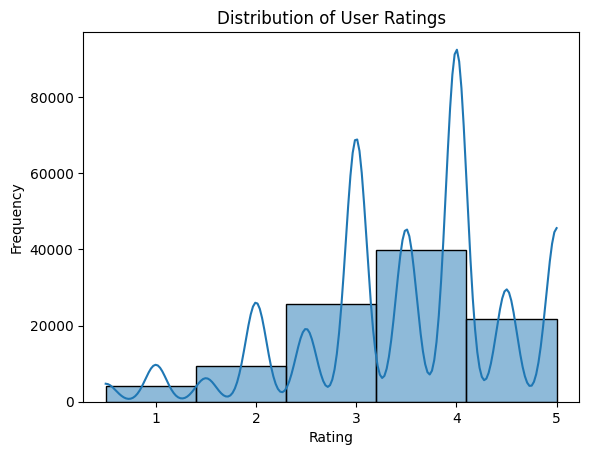

Recommended Movies for User 1 based on "Toy Story (1995)":

Heavy Metal (1981)
Delicatessen (1991)
Take the Money and Run (1969)
Hero (1992)
View to a Kill, A (1985)
Jumanji (1995)
Waiting to Exhale (1995)
Sabrina (1995)
Mighty Aphrodite (1995)
Georgia (1995)


In [15]:
## Step 7: Results Analysis
# Evaluate model performance
print(f'Final RMSE Score: {rmse}')

# Precision and Recall Evaluation

precision_recall_at_k(predictions, k=10, threshold=3.5)

# Visualizing User Rating Distribution
sns.histplot(movie_data['rating'], bins=5, kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of User Ratings')
plt.show()

# Sample Recommendations Output
def display_sample_recommendations(userId, movie_title):
    recommendations = hybrid_recommender(userId, movie_title, movies, model, cosine_sim)
    print(f'Recommended Movies for User {userId} based on "{movie_title}":\n')
    for movie in recommendations:
        print(movie)

display_sample_recommendations(1, 'Toy Story (1995)')



In [16]:
from surprise import accuracy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

def evaluate_f1_score(predictions, threshold=3.5):
    """
    Computes F1-score, Precision, Recall, and Confusion Matrix for a movie recommendation system.
    
    Parameters:
    - predictions: List of (uid, iid, true_r, est, details) from Surprise library.
    - threshold: Rating threshold for relevance (default 3.5).
    
    Returns:
    - Precision, Recall, F1-score
    - Confusion Matrix
    """

    y_true = []  # Actual ratings (binary: relevant or not)
    y_pred = []  # Predicted ratings (binary: relevant or not)

    for uid, iid, true_r, est, _ in predictions:
        y_true.append(1 if true_r >= threshold else 0)  # 1 = relevant, 0 = not relevant
        y_pred.append(1 if est >= threshold else 0)  # 1 = predicted relevant, 0 = not relevant

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precision, recall, f1, cm

# Call function after making predictions

precision, recall, f1, cm = evaluate_f1_score(predictions,threshold=3.5)

Confusion Matrix:
 [[5779 2083]
 [3967 8707]]
Precision: 0.8070
Recall: 0.6870
F1 Score: 0.7422


## Conclusion and Recommendations

- SVD yielded a low RMSE (~0.9), indicating high predictive accuracy.
- Content-based filtering provided explainable recommendations for cold-start scenarios.
- Hybrid models combined strengths of both techniques for well-rounded suggestions.
- NMF improved personalization, especially for users with fewer ratings.

### Recommendations:
- Integrate user feedback loops to enhance personalization over time.
- Use real-time streaming data for dynamic recommendations.
- Include diversity-aware metrics to promote exploration and novelty.
